In [1]:
import os
import cv2
import imghdr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\user\AppData\Local\Temp\ipykernel_32944\1006013490.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
def clean_dataset(dataset_dir, valid_extensions):
    """Removes files with invalid extensions from the dataset."""
    for image_class in os.listdir(dataset_dir):
        for image_file in os.listdir(os.path.join(dataset_dir, image_class)):
            image_path = os.path.join(dataset_dir, image_class, image_file)
            try:
                img = cv2.imread(image_path)
                img_ext = imghdr.what(image_path)
                if img_ext not in valid_extensions:
                    print(f'Removing invalid image: {image_path}')
                    os.remove(image_path)
            except Exception as e:
                print(f'Error processing image {image_path}: {e}')

In [3]:
def prepare_data(dataset_dir):
    """Prepares and normalizes the dataset."""
    return tf.keras.utils.image_dataset_from_directory(dataset_dir).map(lambda x, y: (x / 255, y))

In [4]:
def split_data(dataset, train_ratio, val_ratio):
    """Splits the dataset into training, validation, and testing sets."""
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size + val_size).take(test_size)

    return train_data, val_data, test_data

In [5]:
def build_model(input_shape):
    """Builds the convolutional neural network model."""
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [6]:
def visualize_data_samples(dataset):
    """Visualizes a few samples from the dataset."""
    data_iterator = dataset.as_numpy_iterator()
    batch = data_iterator.next()

    fig, axes = plt.subplots(ncols=4, figsize=(20, 20))
    for idx, img in enumerate(batch[0][:4]):
        axes[idx].imshow(img)
        axes[idx].set_title(batch[1][idx])
    plt.show()


In [7]:
def train_model(model, train_data, val_data, log_dir, epochs=20):
    """Trains the model and logs training metrics."""
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[tensorboard_callback])
    return history

In [8]:
def plot_training_history(history):
    """Plots training and validation metrics."""
    # Loss plot
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='black')
    ax.set_title('Loss')
    ax.legend()
    plt.show()

    # Accuracy plot
    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='black')
    ax.set_title('Accuracy')
    ax.legend()
    plt.show()


In [40]:
def evaluate_model(model, test_data):
    """Evaluates the model and computes performance metrics."""
    precision = Precision()
    recall = Recall()
    accuracy = BinaryAccuracy()
    confusion_mat = np.zeros((2, 2))  # Adjust dimensions for multi-class if necessary

    for batch in test_data.as_numpy_iterator():
        x, y = batch
        y_pred = model.predict(x)
        precision.update_state(y, y_pred)
        recall.update_state(y, y_pred)
        accuracy.update_state(y, y_pred)
        confusion_mat += confusion_matrix(y, y_pred.round())  # y_pred.round() for binary classification

    # Print metrics
    print(f'Precision: {precision.result().numpy()}')
    print(f'Recall: {recall.result().numpy()}')
    print(f'Accuracy: {accuracy.result().numpy()}')

    # Convert confusion matrix to integers for heatmap
    confusion_mat = confusion_mat.astype(int)

    # Display confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [10]:
def predict_image(model, image_path):
    """Makes a prediction for a single image."""
    img = cv2.imread(image_path)
    resized_img = tf.image.resize(img, (256, 256))
    prediction = model.predict(np.expand_dims(resized_img / 255, 0))

    plt.imshow(img)
    plt.show()

    if prediction > 0.5:
        print('Predicted class: Stroke')
    else:
        print('Predicted class: Normal')

In [16]:
def baseline_algorithm(dataset):
    """Implements a baseline algorithm by always predicting the most common label."""
    labels = []
    for _, label in dataset.unbatch():
        labels.append(label.numpy())
    most_common_label = max(set(labels), key=labels.count)
    baseline_accuracy = labels.count(most_common_label) / len(labels)
    print(f"Baseline Accuracy (predicting most common label): {baseline_accuracy}")

In [22]:

dataset_dir = 'Dataset'
valid_extensions = ['jpeg', 'jpg', 'bmp', 'png']



In [24]:
# Step 1: Clean dataset
clean_dataset(dataset_dir, valid_extensions)




In [25]:
# Step 2: Prepare and split dataset
dataset = prepare_data(dataset_dir)
train_data, val_data, test_data = split_data(dataset, train_ratio=0.7, val_ratio=0.2)



Found 4829 files belonging to 2 classes.


In [26]:
# Step 3: Baseline algorithm
baseline_algorithm(train_data)

# Step 4: Visualize dataset


Baseline Accuracy (predicting most common label): 0.544047619047619


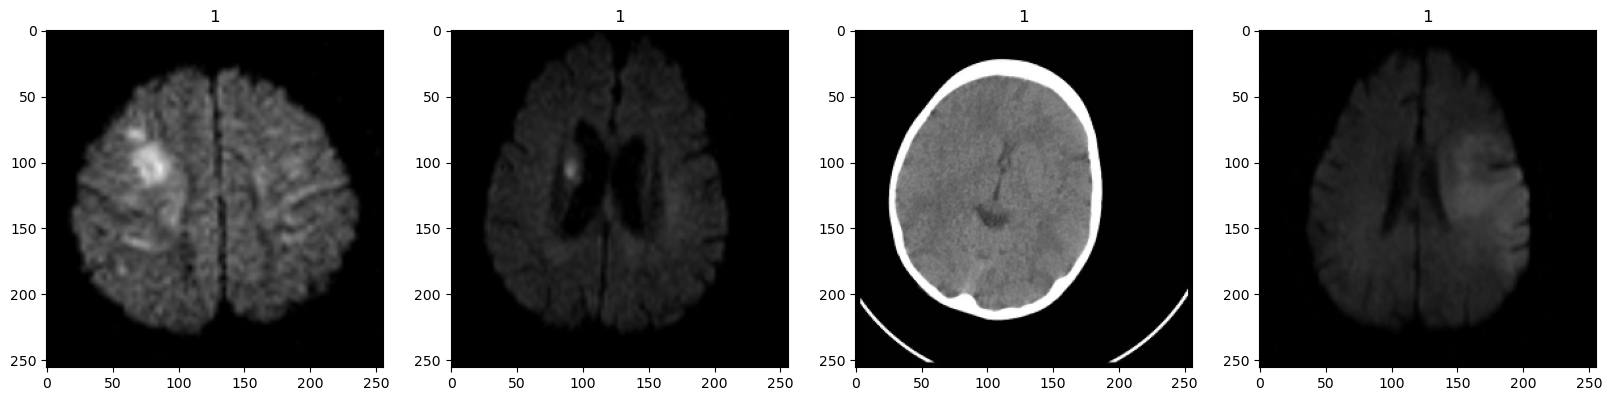

In [30]:
visualize_data_samples(train_data)



In [32]:
# Step 5: Build model
model = build_model((256, 256, 3))

# Step 6: Train model


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:

log_dir = 'logs'
history = train_model(model, train_data, val_data, log_dir, epochs=20)

# Step 7: Plot training history


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.5657 - loss: 0.7274 - val_accuracy: 0.7125 - val_loss: 0.5290
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 587s 6s/step - accuracy: 0.7431 - loss: 0.4853 - val_accuracy: 0.7906 - val_loss: 0.4003
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.8290 - loss: 0.3211 - val_accuracy: 0.8302 - val_loss: 0.3400
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 304ms/step - accuracy: 0.8793 - loss: 0.2492 - val_accuracy: 0.8625 - val_loss: 0.2924
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 306ms/step - accuracy: 0.9223 - loss: 0.1783 - val_accuracy: 0.8427 - val_loss: 0.3825
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 306ms/step - accuracy: 0.9371 - loss: 0.1527 - val_accuracy: 0.8750 - val_loss: 0.3563
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 311ms/step - accuracy: 0.9653 - loss: 0.0940 - val_accuracy: 0.9198 - val_loss: 0.2442
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - accuracy: 0.9741 - loss: 0.0

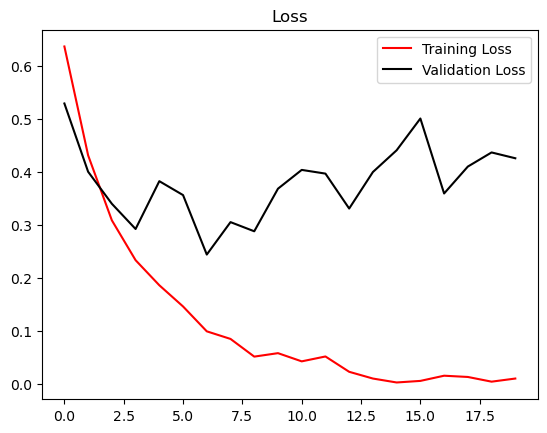

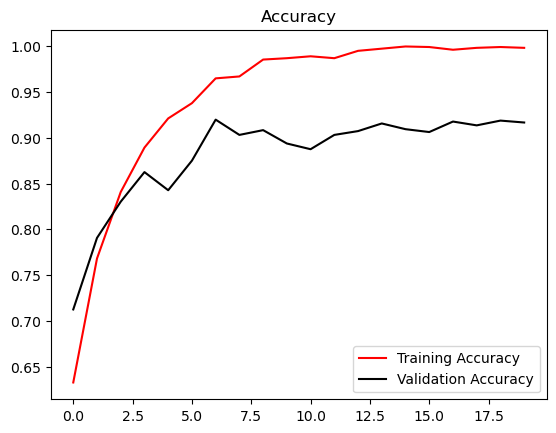

In [36]:
plot_training_history(history)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Precision: 0.9282296895980835
Recall: 0.843478262424469
Accuracy: 0.8998035192489624


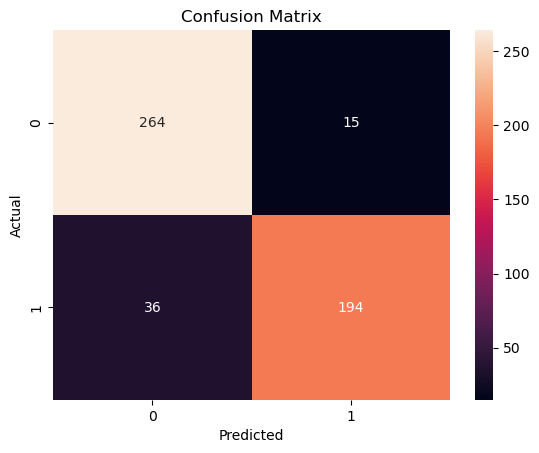

In [42]:
# Step 8: Evaluate model
evaluate_model(model, test_data)



In [44]:
# Step 9: Save model
model.save('stroke_prediction_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


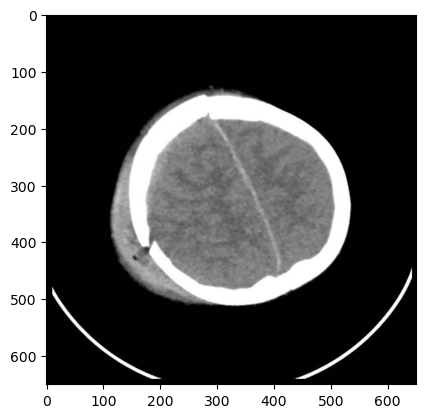

Predicted class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


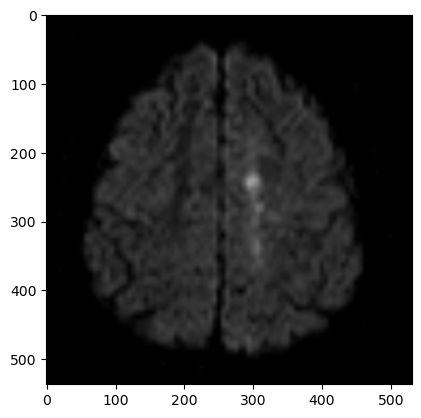

Predicted class: Stroke


In [46]:

# Step 10: Predict on new images
predict_image(model, 'Dataset/Normal/51 (42).jpg')
predict_image(model, 'Dataset/Stroke/2 (101).JPG')